# AE

In [1]:
from keras.models import Sequential 
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
from keras.datasets import mnist
from keras import backend as k
from keras.layers import Lambda
from tensorflow.keras.metrics import binary_crossentropy
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [2]:
data = pd.read_csv('Data.csv')

X = data.drop(['label','Label'], axis = 1)
y = data['label']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [4]:
# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.values.reshape(-1,28,28,1)

X_test = X_test.astype('float32') / 255.
X_test = X_test.values.reshape(-1,28,28,1)

In [5]:
# This is the dimension of the latent space (encoding space)
latent_dim = 2

 
data_shape = (X_train.shape[1], X_train.shape[2])

encoder = Sequential([
    tf.keras.layers.Flatten(input_shape=data_shape),
    Dense(192, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(latent_dim, name='encoder_output')
])

decoder = Sequential([
    Dense(64, activation='relu', input_shape=(latent_dim,)),
    Dense(128, activation='relu'),
    Dense(data_shape[0] * data_shape[1], activation='relu'),
    tf.keras.layers.Reshape(data_shape)
])

In [6]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

In [7]:
model_history = autoencoder.fit(X_train, X_train, epochs=8, batch_size=32, verbose=0)

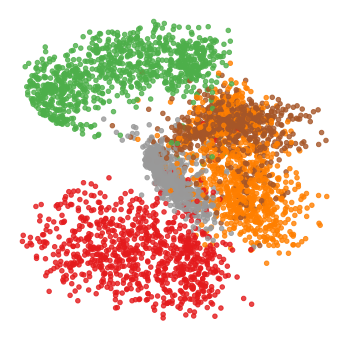

In [8]:
X_te_latent = encoder.predict(X_test, batch_size=256)
plt.figure(figsize=(6, 6))
plt.scatter(X_te_latent[:, 0],  X_te_latent[:, 1], s=20, alpha=0.8, cmap='Set1', c=y_test[0:X_test.shape[0]])
plt.axis('off')
plt.show()

# VAE

In [9]:
data = pd.read_csv('Data.csv')

X = data.drop(['label','Label'], axis = 1)
y = data['label']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [11]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.values.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.values.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(17132, 784)
(4284, 784)


In [12]:
batch_size, n_epoch = 100, 150
latent_dim = 2

input_data = Input(shape=(X_train[0].shape))
X = Dense(200, activation='relu')(input_data)
X= Dense(100, activation='relu')(X)
X = Dense(30, activation='relu')(X)

mu = Dense(latent_dim)(X)
log_var = Dense(latent_dim)(X)

encoder = Model(input_data, mu, name='Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 200)               157000    
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 dense_8 (Dense)             (None, 30)                3030      
                                                                 
 dense_9 (Dense)             (None, 2)                 62        
                                                                 
Total params: 180,192
Trainable params: 180,192
Non-trainable params: 0
_________________________________________________________________


In [13]:
def sampling(args):
    mu, log_var = args
    eps = k.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return mu + k.exp(log_var) * eps

z = Lambda(sampling, output_shape=(latent_dim,))([mu, log_var])

In [14]:
z_decoder1 = Dense(30, activation='relu')
z_decoder2 = Dense(100, activation='relu')
z_decoder3 = Dense(200, activation='relu')
y_decoder = Dense((X_train[0].shape[0]), activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
z_decoded = z_decoder3(z_decoded)
y = y_decoder(z_decoded)

decoder = Model(z, y, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(100, 2)]                0         
                                                                 
 dense_11 (Dense)            (100, 30)                 90        
                                                                 
 dense_12 (Dense)            (100, 100)                3100      
                                                                 
 dense_13 (Dense)            (100, 200)                20200     
                                                                 
 dense_14 (Dense)            (100, 784)                157584    
                                                                 
Total params: 180,974
Trainable params: 180,974
Non-trainable params: 0
_________________________________________________________________


In [15]:
reconstruction_loss = binary_crossentropy(input_data, y) * X_train[0].shape
kl_loss = 0.5 * k.sum(k.square(mu) + k.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

vae = Model(input_data, y, name='VAE')
vae.add_loss(vae_loss)

vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 200)          157000      ['input_1[0][0]']                
                                                                                                  
 dense_7 (Dense)                (None, 100)          20100       ['dense_6[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 30)           3030        ['dense_7[0][0]']                
                                                                                                

In [16]:
P = X_train[:17000,]

In [17]:
vae.compile(optimizer='rmsprop')
history = vae.fit(P, shuffle=True, epochs=14, batch_size=batch_size, validation_data=(P, None), verbose=1)

Epoch 1/14
170/170 [==============================] - 3s 10ms/step - loss: 226.8791 - val_loss: 190.1064
Epoch 2/14
170/170 [==============================] - 1s 8ms/step - loss: 179.9564 - val_loss: 173.4556
Epoch 3/14
170/170 [==============================] - 1s 8ms/step - loss: 167.2917 - val_loss: 161.6042
Epoch 4/14
170/170 [==============================] - 1s 8ms/step - loss: 157.2810 - val_loss: 154.7213
Epoch 5/14
170/170 [==============================] - 1s 8ms/step - loss: 153.5341 - val_loss: 151.5322
Epoch 6/14
170/170 [==============================] - 1s 8ms/step - loss: 150.7019 - val_loss: 148.3072
Epoch 7/14
170/170 [==============================] - 1s 8ms/step - loss: 147.9546 - val_loss: 146.2944
Epoch 8/14
170/170 [==============================] - 1s 8ms/step - loss: 145.6458 - val_loss: 145.1714
Epoch 9/14
170/170 [==============================] - 1s 8ms/step - loss: 143.6963 - val_loss: 142.7827
Epoch 10/14
170/170 [==============================] - 1s 9ms/s

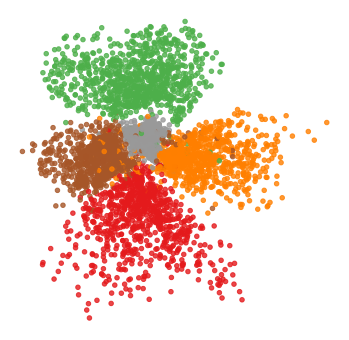

In [18]:
x_te_latent = encoder.predict(X_test, batch_size=256)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], s=20, alpha=0.8, cmap='Set1', c=y_test[0:X_test.shape[0]])
plt.axis('off')   
plt.show()

# VAEC

In [19]:
data = pd.read_csv('Data.csv')

X = data.drop(['label','Label'], axis = 1)
y = data['label']

In [20]:
# Label encoding y
lbl = LabelEncoder()
y = lbl.fit_transform(y)

# Converting it into a categorical variable
y = to_categorical(y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [22]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.values.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.values.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(17132, 784)
(4284, 784)


In [23]:
vaec = Sequential(name='VAEC')

# Adding a 2D convolution layer
vaec.add(encoder)

# Adding a dense layer with softmax activation
vaec.add(Dense(5, activation="softmax"))

vaec.summary()

Model: "VAEC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Functional)        (None, 2)                 180192    
                                                                 
 dense_15 (Dense)            (None, 5)                 15        
                                                                 
Total params: 180,207
Trainable params: 180,207
Non-trainable params: 0
_________________________________________________________________


In [24]:
opt = Adam(lr=1e-3, decay=1e-5)

# Configuring the model for training
vaec.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model
vaec_history = vaec.fit(X_train, y_train, epochs=10, batch_size=5, validation_split=0.2)

Epoch 1/10


C:\Users\Pradip\AppData\Roaming\Python\Python310\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2741/2741 [==============================] - 7s 2ms/step - loss: 0.2555 - accuracy: 0.9306 - val_loss: 0.0696 - val_accuracy: 0.9761
Epoch 2/10
2741/2741 [==============================] - 5s 2ms/step - loss: 0.0691 - accuracy: 0.9814 - val_loss: 0.0620 - val_accuracy: 0.9813
Epoch 3/10
2741/2741 [==============================] - 6s 2ms/step - loss: 0.0429 - accuracy: 0.9880 - val_loss: 0.0749 - val_accuracy: 0.9807
Epoch 4/10
2741/2741 [==============================] - 5s 2ms/step - loss: 0.0337 - accuracy: 0.9907 - val_loss: 0.0448 - val_accuracy: 0.9907
Epoch 5/10
2741/2741 [==============================] - 5s 2ms/step - loss: 0.0237 - accuracy: 0.9935 - val_loss: 0.0574 - val_accuracy: 0.9875
Epoch 6/10
2741/2741 [==============================] - 5s 2ms/step - loss: 0.0175 - accuracy: 0.9947 - val_loss: 0.0519 - val_accuracy: 0.9886
Epoch 7/10
2741/2741 [==============================] - 5s 2ms/step - loss: 0.0161 - accuracy: 0.9961 - val_loss: 0.1007 - val_accuracy: 0.9822
Epo

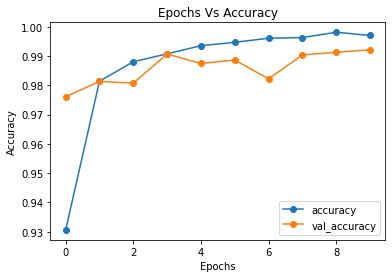

In [25]:
plt.plot(np.array((vaec_history.history)['accuracy']),'-o')
plt.plot(np.array((vaec_history.history)['val_accuracy']),'-o')
plt.title("Epochs Vs Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['accuracy','val_accuracy'])
plt.show()

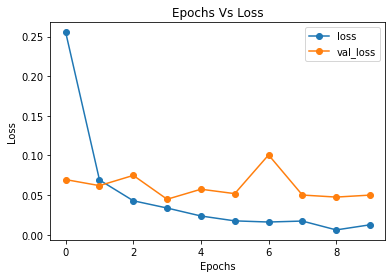

In [26]:
plt.plot(np.array((vaec_history.history)['loss']),'-o')
plt.plot(np.array((vaec_history.history)['val_loss']),'-o')
plt.title("Epochs Vs Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['loss','val_loss'])
plt.show()

In [27]:
model = vaec
predictions = model.predict(X_test)

In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

134/134 [==============================] - 0s 1ms/step - loss: 0.0871 - accuracy: 0.9874
Test loss: 0.08711662888526917
Test accuracy: 0.9873949289321899


In [29]:
y_pred = [np.argmax(np.round(predictions[i])) for i in range(len(X_test))]
y_true = [np.argmax(y_test[i]) for i in range(len(X_test))]

In [30]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuPu):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

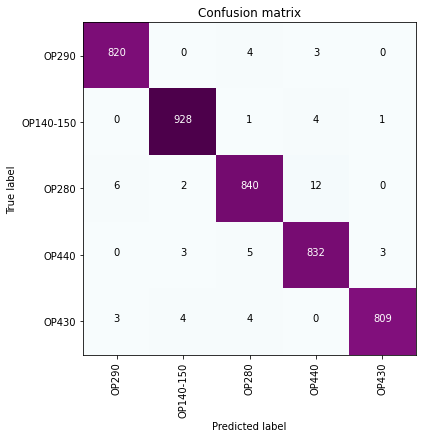

In [31]:
cm = confusion_matrix(y_true,y_pred)
cm_plot = plot_confusion_matrix(cm,classes=[str(i) for i in set(data['Label'])])